### 安装所需要的依赖包


pip install tiktoken openai pandas matplotlib plotly scikit-learn numpy

### 生成 Embedding (基于 text-embedding-ada-002 模型)

Embedding对于处理自然语言和代码非常有用，因为其他机器学习模型和算法（如聚类或搜索）可以轻松地使用和比较它们。

![embedding](images/embedding-vectors.svg)

### 亚马逊美食评论数据集(amazon-fine-food-reviews)

Source:[美食评论数据集](https://www.kaggle.com/snap/amazon-fine-food-reviews)

![dataset](images/amazon-fine-food-reviews.png)


该数据集包含截至2012年10月用户在亚马逊上留下的共计568,454条美食评论。为了说明目的，我们将使用该数据集的一个子集，其中包括最近1,000条评论。这些评论都是用英语撰写的，并且倾向于积极或消极。每个评论都有一个产品ID、用户ID、评分、标题（摘要）和正文。

我们将把评论摘要和正文合并成一个单一的组合文本。模型将对这个组合文本进行编码，并输出一个单一的向量嵌入。

In [1]:
import pandas as pd
#导入tiktoken库 Tiktoken是OpenAI开发的一个库，用于从模型生成的文本中计算token数量。
import tiktoken

### 加载数据集

In [2]:
input_datapath = 'data/fine_food_reviews_1k.csv'

In [3]:
#读取数据，不要第一列
df = pd.read_csv(input_datapath,index_col=0)

In [4]:
# 获取表头为'Time', 'ProductId', 'UserId', 'Score', 'Summary', 'Text'的数据
df = df[['Time', 'ProductId', 'UserId', 'Score', 'Summary', 'Text']]

In [5]:
# 去掉为nan的数据行
df = df.dropna()

In [6]:
df.head()

,Time,ProductId,UserId,Score,Summary,Text
0,1351123200,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...
1,1351123200,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos..."
2,1351123200,B000JMBE7M,AQX1N6A51QOKG,4,"It isn't blanc mange, but isn't bad . . .",I'm not sure that custard is really custard wi...
3,1351123200,B004AHGBX4,A2UY46X0OSNVUQ,3,These also have SALT and it's not sea salt.,I like the fact that you can see what you're g...
4,1351123200,B001BORBHO,A1AFOYZ9HSM2CZ,5,Happy with the product,My dog was suffering with itchy skin. He had ...


In [7]:
# 添加新的列，将 "Summary" 和 "Text" 字段组合成新的字段 "combined"
df['combined'] = (
    "Title: " + df.Summary.str.strip() + '; Content: '+ df.Text.str.strip()
)

In [8]:
df.head(5)

,Time,ProductId,UserId,Score,Summary,Text,combined
0,1351123200,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...
1,1351123200,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Title: Arrived in pieces; Content: Not pleased...
2,1351123200,B000JMBE7M,AQX1N6A51QOKG,4,"It isn't blanc mange, but isn't bad . . .",I'm not sure that custard is really custard wi...,"Title: It isn't blanc mange, but isn't bad . ...."
3,1351123200,B004AHGBX4,A2UY46X0OSNVUQ,3,These also have SALT and it's not sea salt.,I like the fact that you can see what you're g...,Title: These also have SALT and it's not sea s...
4,1351123200,B001BORBHO,A1AFOYZ9HSM2CZ,5,Happy with the product,My dog was suffering with itchy skin. He had ...,Title: Happy with the product; Content: My dog...


In [9]:
df['combined']

0      Title: where does one  start...and stop... wit...
1      Title: Arrived in pieces; Content: Not pleased...
2      Title: It isn't blanc mange, but isn't bad . ....
3      Title: These also have SALT and it's not sea s...
4      Title: Happy with the product; Content: My dog...
                             ...                        
995    Title: Delicious!; Content: I have ordered the...
996    Title: Good Training Treat; Content: My dog wi...
997    Title: Jamica Me Crazy Coffee; Content: Wolfga...
998    Title: Party Peanuts; Content: Great product f...
999    Title: I love Maui Coffee!; Content: My first ...
Name: combined, Length: 1000, dtype: object

### Embedding 模型关键参数

In [10]:
# 模型类型
embedding_model = 'text-embedding-ada-002'
# text-embedding-ada-002 模型对应的分词器（TOKENIZER）
embedding_encoding = 'cl100k_base'
# text-embedding-ada-002 模型支持的输入最大 Token 数是8191，向量维度 1536
# 在我们的 DEMO 中过滤 Token 超过 8000 的文本
max_tokens = 8000  

### 生成 Embeddings 并保存

In [11]:
from openai import OpenAI
import openai

In [12]:
openai.api_key = ''

In [13]:
# 初始化对象
client = OpenAI()

In [14]:
res = client.embeddings.create(input='hello', model=embedding_model)

In [15]:
res.data[0].embedding[:10]

[-0.02515980415046215,
 -0.01951141469180584,
 -0.02793770097196102,
 -0.03100661374628544,
 -0.02473650500178337,
 0.02762022614479065,
 -0.012619586661458015,
 -0.008446128107607365,
 -0.01756688766181469,
 -0.00835353136062622]

In [16]:
# 使用新方法调用 OpenAI Embedding API
def embedding_text(text, model="text-embedding-ada-002"):
    res = client.embeddings.create(input=text, model=model)
    return res.data[0].embedding

In [17]:
# 实际生成会耗时几分钟，逐行调用 OpenAI Embedding API
df["embedding"] = df.combined.apply(embedding_text)

output_datapath = "data/fine_food_reviews_with_embeddings_1k_1126.csv"

df.to_csv(output_datapath)

### 读取保存Embedding向量后的文件

In [18]:
embedding_datapath = 'data/fine_food_reviews_with_embeddings_1k_1126.csv'

In [19]:
df_embedding = pd.read_csv(embedding_datapath, index_col=0)

In [20]:
df_embedding['embedding']

0      [0.007000929210335016, -0.027453815564513206, ...
1      [-0.023633742704987526, -0.011830238625407219,...
2      [0.0001991958706639707, 0.005254689138382673, ...
3      [0.010417347773909569, -0.013515103608369827, ...
4      [0.015346125699579716, -0.003973433747887611, ...
                             ...                        
995    [-0.008589736185967922, -0.018665263429284096,...
996    [-0.024556949734687805, -0.01762823946774006, ...
997    [-0.016896171495318413, -0.005281670950353146,...
998    [-0.010792471468448639, -0.016494281589984894,...
999    [-0.006112170405685902, -0.015096442773938179,...
Name: embedding, Length: 1000, dtype: object

In [21]:
import ast

In [22]:
# 将字符串转换为向量
df_embedding["embedding_vec"] = df_embedding["embedding"].apply(ast.literal_eval)

In [23]:
len(df_embedding['embedding_vec'][0])

1536

In [25]:
df_embedding['embedding_vec'][0]

[0.007000929210335016,
 -0.027453815564513206,
 0.010571849532425404,
 -0.014572381041944027,
 0.0044095199555158615,
 0.019988907501101494,
 0.0007045608945190907,
 -0.022064784541726112,
 -0.01924654096364975,
 -0.013534442521631718,
 0.018078001216053963,
 0.0040280260145664215,
 -0.03302156552672386,
 0.0001496117765782401,
 0.01585090160369873,
 0.01945275440812111,
 0.017816798761487007,
 -0.026312770321965218,
 -0.01938401535153389,
 -0.025130484253168106,
 -0.04753895476460457,
 -0.007244947832077742,
 0.023783225566148758,
 -0.008633448742330074,
 -0.009018379263579845,
 0.011396701447665691,
 0.02958468347787857,
 -0.022490957751870155,
 -0.010166297666728497,
 0.02167985402047634,
 0.0011479186359792948,
 0.009080243296921253,
 -0.01330073457211256,
 -0.01733563467860222,
 -0.005763651803135872,
 -0.010929285548627377,
 -0.026477741077542305,
 0.007396170869469643,
 0.022587191313505173,
 -0.02029135264456272,
 0.018985338509082794,
 -0.015424727462232113,
 0.009320824407041

### 使用 t-SNE 可视化 1536 维 Embedding 美食评论

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# 从 sklearn.manifold 模块中导入 TSNE 类。
# TSNE (t-Distributed Stochastic Neighbor Embedding) 是一种用于数据可视化的降维方法，尤其擅长处理高维数据的可视化。
# 它可以将高维度的数据映射到 2D 或 3D 的空间中，以便我们可以直观地观察和理解数据的结构。
from sklearn.manifold import TSNE

In [27]:
# 将嵌入向量列表转换为二维 numpy 数组
matrix = np.vstack(df_embedding['embedding_vec'].values)

In [28]:
matrix

array([[ 0.00700093, -0.02745382,  0.01057185, ..., -0.00713497,
        -0.0219548 , -0.03753075],
       [-0.02363374, -0.01183024,  0.00040896, ..., -0.01479782,
         0.00733876, -0.03328508],
       [ 0.0001992 ,  0.00525469,  0.00251072, ...,  0.01034277,
        -0.00613103, -0.01213543],
       ...,
       [-0.01689617, -0.00528167,  0.00616141, ..., -0.01831928,
        -0.00975476, -0.02232986],
       [-0.01079247, -0.01649428,  0.02220281, ..., -0.0178106 ,
        -0.03121556, -0.00426125],
       [-0.00611217, -0.01509644, -0.00206127, ..., -0.0290727 ,
        -0.01417164, -0.02287261]])

In [29]:
# 创建一个 t-SNE 模型，t-SNE 是一种非线性降维方法，常用于高维数据的可视化。
# n_components 表示降维后的维度（在这里是2D）
# perplexity 可以被理解为近邻的数量
# random_state 是随机数生成器的种子
# init 设置初始化方式
# learning_rate 是学习率。
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)

In [30]:
# 使用 t-SNE 对数据进行降维，得到每个数据点在新的2D空间中的坐标
vis_dims = tsne.fit_transform(matrix)

In [31]:
vis_dims.shape

(1000, 2)

In [32]:
# 定义了五种不同的颜色，用于在可视化中表示不同的等级
colors = ["red", "darkorange", "gold", "turquoise", "darkgreen"]

In [33]:
x = vis_dims[:,0].tolist()
y = vis_dims[:,1].tolist()
color_indices = df_embedding.Score.values - 1
# 创建一个基于预定义颜色的颜色映射对象
colormap = matplotlib.colors.ListedColormap(colors)

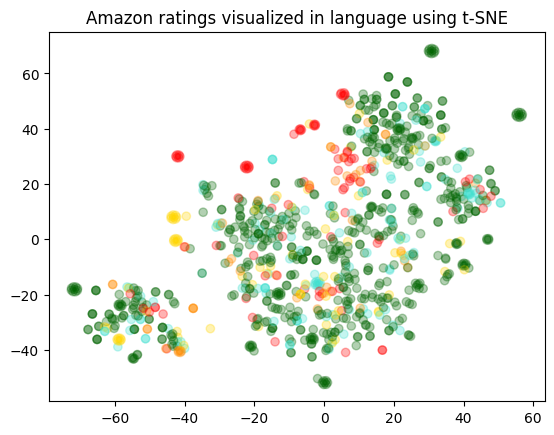

In [34]:
# 为图形添加标题
plt.title("Amazon ratings visualized in language using t-SNE")
# x, y: 这是两个长度相同的数组，分别表示散点图中每个点的 X 轴和 Y 轴坐标。
# c: 点的颜色，可以是单个颜色格式的字符串，一个颜色序列，或者一组数值，使用 cmap 参数映射到颜色上。
# cmap: cmap 是 Colormap 的缩写，用于当 c 参数为数字时，将数字映射到颜色。
# alpha: 透明度，介于 0（完全透明）和 1（完全不透明）之间的小数。

plt.scatter(x,y, c=color_indices, cmap=colormap,alpha=0.3)
plt.show()

### 使用 K-Means 聚类，然后使用 t-SNE 可视化

In [35]:
from sklearn.cluster import KMeans

In [36]:
# np.vstack 是一个将输入数据堆叠到一个数组的函数（在垂直方向）。
# 这里它用于将所有的 ada_embedding 值堆叠成一个矩阵。

matrix = np.vstack(df_embedding['embedding_vec'].values)

In [37]:
n_clusters = 4
# 初始化kMeans
# n_clusters 参数指定了要创建的聚类的数量
# init 参数指定了初始化方法（在这种情况下是 'k-means++'）
# random_state 参数为随机数生成器设定了种子值，用于生成初始聚类中心。
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, )

In [38]:
kmeans.fit(matrix)

C:\Users\sin\.conda\envs\langchaindemo\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=4, random_state=42)

In [39]:
# 在数据中添加一列
df_embedding['Cluster'] = kmeans.labels_

In [40]:
df_embedding.head(2)

,Time,ProductId,UserId,Score,Summary,Text,combined,embedding,embedding_vec,Cluster
0,1351123200,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...,"[0.007000929210335016, -0.027453815564513206, ...","[0.007000929210335016, -0.027453815564513206, ...",2
1,1351123200,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Title: Arrived in pieces; Content: Not pleased...,"[-0.023633742704987526, -0.011830238625407219,...","[-0.023633742704987526, -0.011830238625407219,...",2


In [41]:
colors = ['red', 'green', 'blue', 'purple']

In [42]:
tsne_model = TSNE(n_components=2, random_state=42)
vis_data = tsne_model.fit_transform(matrix)

In [43]:
x,y = vis_data[:,0], vis_data[:,1]
# 'Cluster' 列中的值将被用作颜色索引。
colors_indices = df_embedding['Cluster'].values
colormap = matplotlib.colors.ListedColormap(colors)

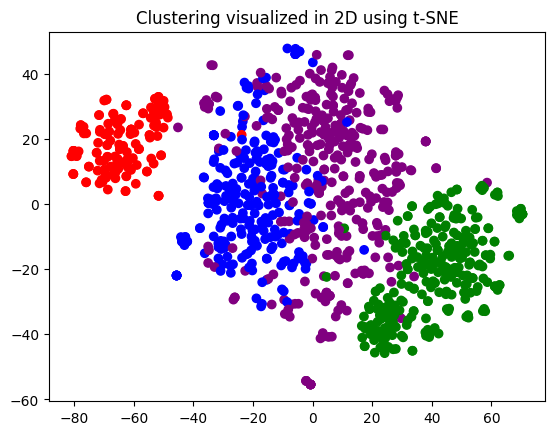

In [44]:
plt.scatter(x,y, c=colors_indices, cmap=colormap)
# 为图形添加标题
plt.title("Clustering visualized in 2D using t-SNE")
# 显示图形
plt.show()

###  使用 Embedding 进行文本搜索

In [45]:
# cosine_similarity 函数计算两个嵌入向量之间的余弦相似度。
# 余弦相似度 = a*b / |a|*|b|
def cosine_similarity(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    cosine_similarity  = dot_product / (norm_a * norm_b)
    return cosine_similarity

In [46]:
def search_reviews(df, product_description, n=3, pprint=True):
    product_embedding = embedding_text(product_description)
    df['similarity'] = df.embedding_vec.apply(lambda x:cosine_similarity(x, product_embedding))
    results = (
        df.sort_values('similarity', ascending=False).head(n).combined.str.replace("Title: ", "").str.replace("; Content:", ": ")
    )
    if pprint:
        for r in results:
            print(r[:200])
            print()
    return results

In [47]:
df_embedding.embedding

0      [0.007000929210335016, -0.027453815564513206, ...
1      [-0.023633742704987526, -0.011830238625407219,...
2      [0.0001991958706639707, 0.005254689138382673, ...
3      [0.010417347773909569, -0.013515103608369827, ...
4      [0.015346125699579716, -0.003973433747887611, ...
                             ...                        
995    [-0.008589736185967922, -0.018665263429284096,...
996    [-0.024556949734687805, -0.01762823946774006, ...
997    [-0.016896171495318413, -0.005281670950353146,...
998    [-0.010792471468448639, -0.016494281589984894,...
999    [-0.006112170405685902, -0.015096442773938179,...
Name: embedding, Length: 1000, dtype: object

In [48]:
res = search_reviews(df_embedding, 'delicious beans', n=3)

Good Buy:  I liked the beans. They were vacuum sealed, plump and moist. Would recommend them for any use. I personally split and stuck them in some vodka to make vanilla extract. Yum!

Jamaican Blue beans:  Excellent coffee bean for roasting. Our family just purchased another 5 pounds for more roasting. Plenty of flavor and mild on acidity when roasted to a dark brown bean and befor

Delicious!:  I enjoy this white beans seasoning, it gives a rich flavor to the beans I just love it, my mother in law didn't know about this Zatarain's brand and now she is traying different seasoning



In [50]:
res = search_reviews(df_embedding, 'awful', n=5)

God Awful:  As a dabbler who enjoys spanning the entire spectrum of taste, I am more than willing to try anything once.  Both as a food aficionado and a lover of bacon, I just had to pick this up.  On

Just Bad:  Watery and unpleasant.  Like Yoohoo mixed with dirty dish water.  I find it quite odd that Keurig would release a product like this.  I'm sure they can come up with a decent hot chocolate a

Disappointed:  The metal cover has severely disformed. And most of the cookies inside have been crushed into small pieces. Shopping experience is awful. I'll never buy it online again.

Arrived in pieces:  Not pleased at all. When I opened the box, most of the rings were broken in pieces. A total waste of money.

Awesome:  They arrived before the expected time and were of fantastic quality. Would recommend to any one looking for a awesome treat

